In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dataset = pd.read_csv('sign_data/train_data.csv', header = None)
test_dataset = pd.read_csv('sign_data/test_data.csv', header = None)  
train_dir = "sign_data/train"
test_dir = "sign_data/test"

In [3]:
class DataLoader:
    def __init__(self, dataset, batch_size, dir):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = dir
    
    def shuffle(self):
        return self.dataset.sample(frac=1)
    
    def preprocess_image(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=1) 
        img = tf.image.resize(img, (128, 128))
        img = tf.cast(img, tf.uint8) 

        img_cv2 = cv2.Canny(img.numpy(), 20, 220) 
        
        img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0
        
        return img_cv2
    
    def datagen(self):
        num_samples = len(self.dataset)
        while True:

            self.dataset = self.shuffle()
            for batch in range(0, num_samples, self.batch_size):
                image1_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 0]]
                image2_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 1]]
                label_batch_samples = self.dataset.iloc[batch:batch + self.batch_size, 2]
                Image1, Image2, Label = [], [], []
                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):

                    image1_data = self.preprocess_image(image1)
                    image2_data = self.preprocess_image(image2)
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)

                Image1 = np.asarray(Image1)
                Image2 = np.asarray(Image2)
                Label = np.asarray(Label)
                yield {"image1": Image1, "image2": Image2}, Label


In [4]:
train_set, val_set = train_test_split(train_dataset, test_size=0.25)

# Create train, val and test 
train_gen = DataLoader(train_set, 256, train_dir)
val_gen = DataLoader(val_set, 256, train_dir)
test_gen = DataLoader(test_dataset, 256, test_dir)  

Pair 1:
Label: 0


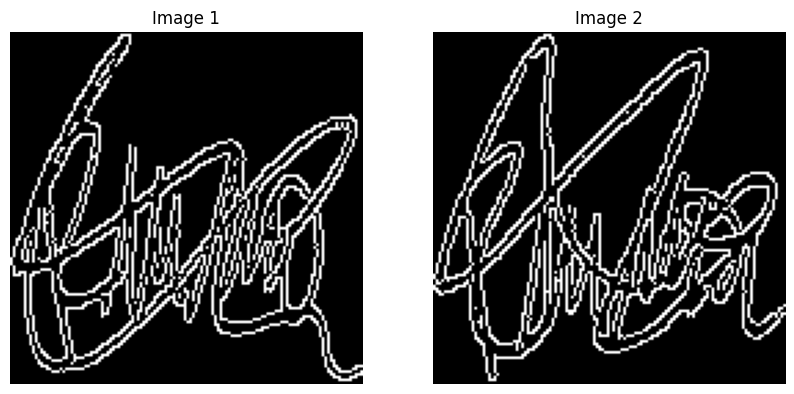

Pair 2:
Label: 0


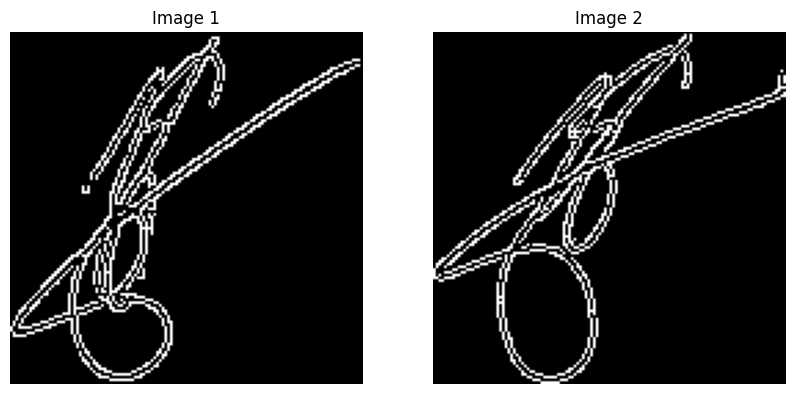

Pair 3:
Label: 1


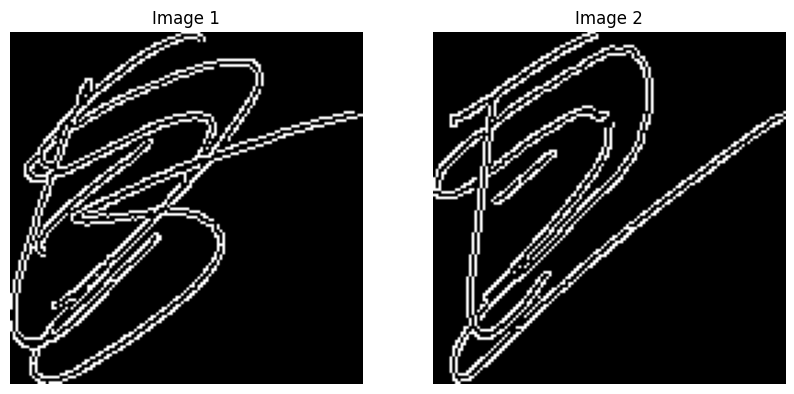

Pair 4:
Label: 1


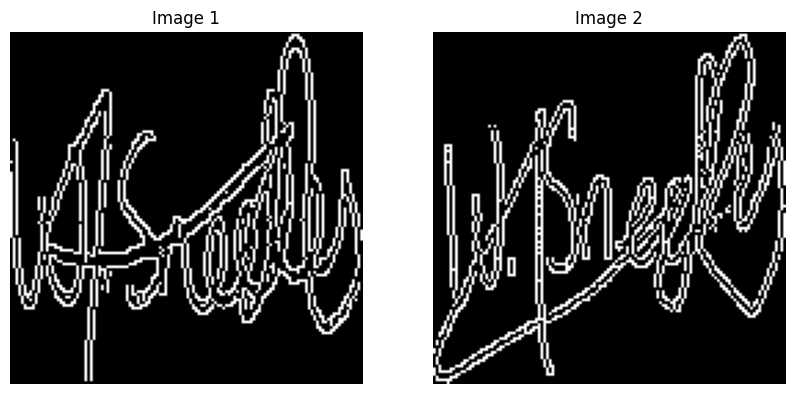

Pair 5:
Label: 1


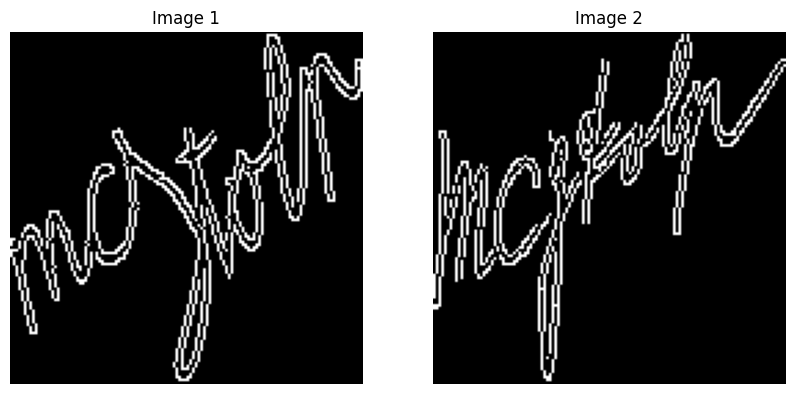

In [5]:

# Create data generator
generator = train_gen.datagen()

# Plot 5 1st images in batch
for i in range(5):
    batch_data, label = next(generator)
    
    pair_data = batch_data["image1"], batch_data["image2"]
    
    print(f"Pair {i+1}:")
    print("Label:", label[0]) 
    
    plt.figure(figsize=(10, 5))
    for j in range(2):
        plt.subplot(1, 2, j+1)
        plt.imshow(pair_data[j][0], cmap='gray')
        plt.title('Image {}'.format(j+1))
        plt.axis('off')
    
    plt.show()


In [6]:

def create_siamese_model(input_shape):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    
    input1 = Input(input_shape, name="image1")
    input2 = Input(input_shape, name="image2")

    embedding1 = model(input1)
    embedding2 = model(input2)

    manhattan_distance_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
    manhattan_distance = manhattan_distance_layer([embedding1, embedding2])


    output = Dense(1, activation='sigmoid')(manhattan_distance)

    return Model(inputs=[input1, input2], outputs=output)

In [7]:
input_shape = (128, 128, 1) 

In [8]:
model = create_siamese_model(input_shape)
model.summary()
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image1 (InputLayer)            [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 image2 (InputLayer)            [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128)          2522624     ['image1[0][0]',                 
                                                                  'image2[0][0]']             

In [9]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model.kernel", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

In [10]:
# Model training
history = model.fit(x=train_gen.datagen(),
                            steps_per_epoch=len(train_set) // 256,
                            epochs=1,
                            validation_data=val_gen.datagen(),
                            validation_steps=len(val_set) // 256,
                            callbacks=callbacks_list)

67/67 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.6490
Epoch 1: val_accuracy improved from -inf to 0.66513, saving model to best_model.kernel


INFO:tensorflow:Assets written to: best_model.kernel\assets


INFO:tensorflow:Assets written to: best_model.kernel\assets


67/67 [==============================] - 367s 5s/step - loss: 0.6273 - accuracy: 0.6490 - val_loss: 0.6061 - val_accuracy: 0.6651


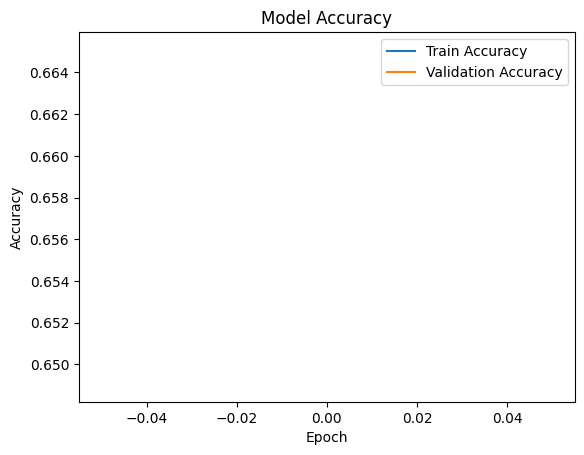

In [11]:
# Train and val model accuracy per epoch
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [12]:

# load weights
model.load_weights("best_model.kernel")

In [13]:
mytest_dir = "sign_data/my_test"
mytest_dataset = pd.read_csv('sign_data/test_data.csv', header = None)

In [14]:
# Testing model on test dataset
test_loss, test_accuracy = model.evaluate(test_gen.datagen(),
                                          steps=len(test_dataset) // 256)

22/22 [==============================] - 48s 2s/step - loss: 0.6113 - accuracy: 0.6456


In [15]:
# Getting image pairs and their labels for the test dataset
test_pairs, test_labels = next(test_gen.datagen())

In [16]:
# Getting predictions for the test dataset
test_predictions = model.predict(test_pairs)

# Conversion of predictions to binary format (0 or 1)
binary_predictions = (test_predictions > 0.5).astype(int)

8/8 [==============================] - 1s 94ms/step


Pair 244
True Label: 0
Predicted Label: [0]


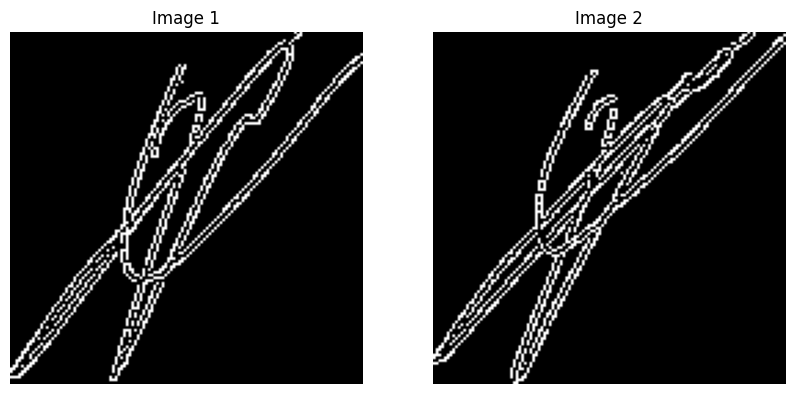

Pair 124
True Label: 1
Predicted Label: [1]


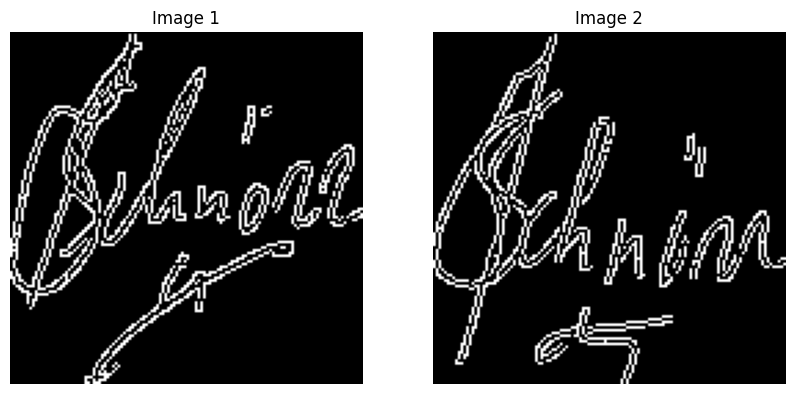

Pair 67
True Label: 1
Predicted Label: [0]


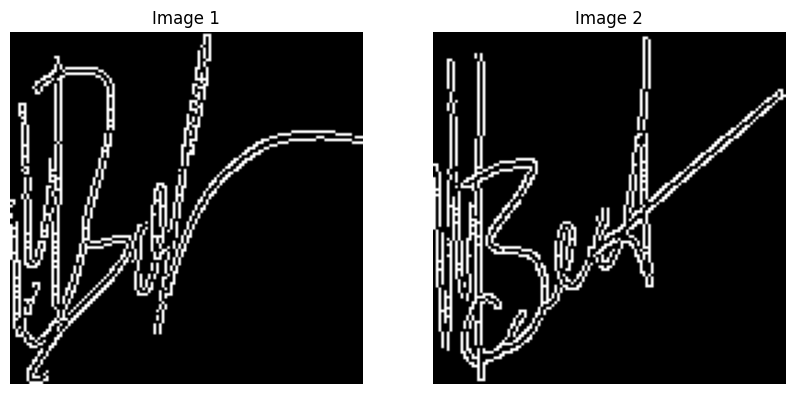

Pair 198
True Label: 0
Predicted Label: [1]


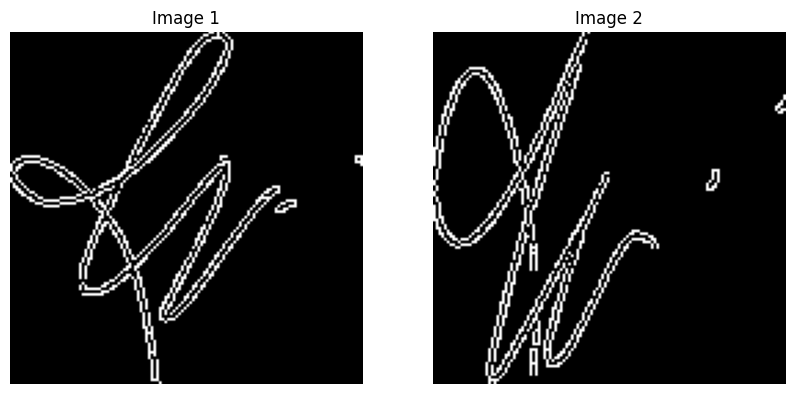

Pair 120
True Label: 1
Predicted Label: [1]


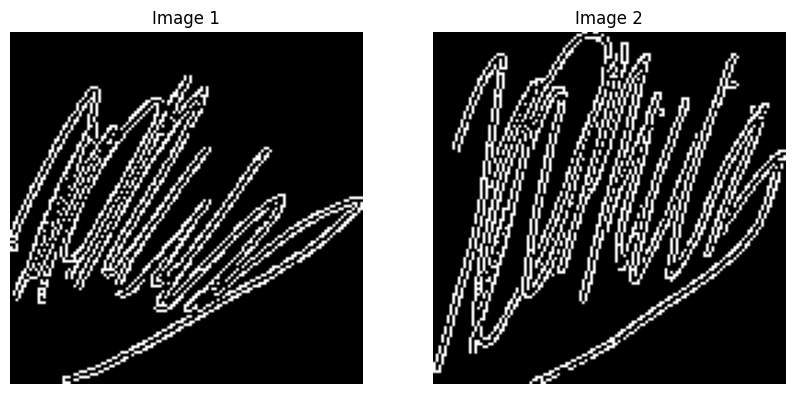

Pair 130
True Label: 1
Predicted Label: [1]


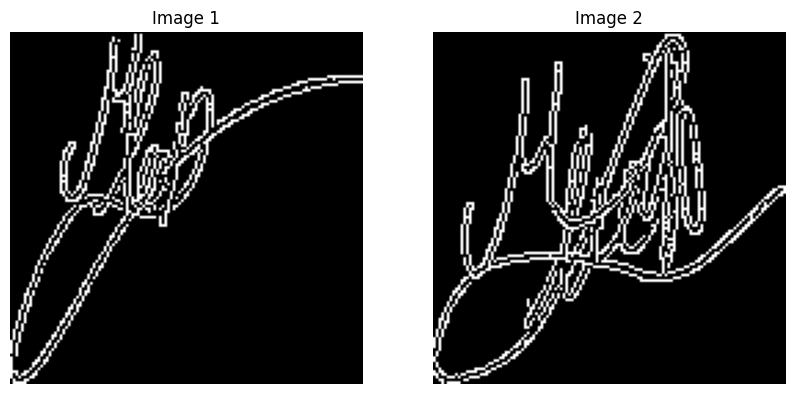

Pair 239
True Label: 1
Predicted Label: [1]


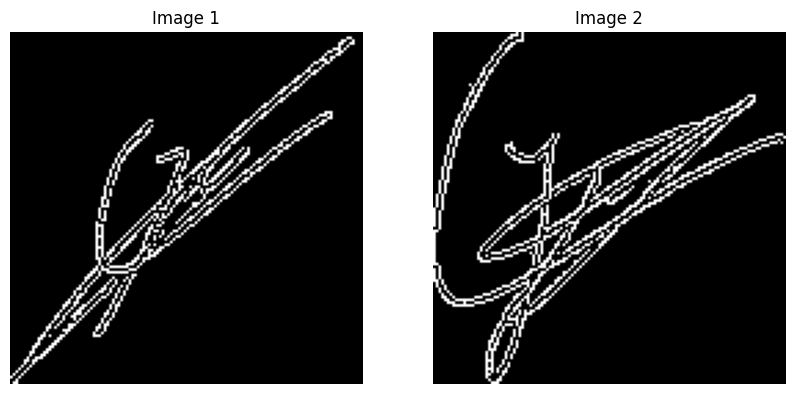

Pair 41
True Label: 0
Predicted Label: [0]


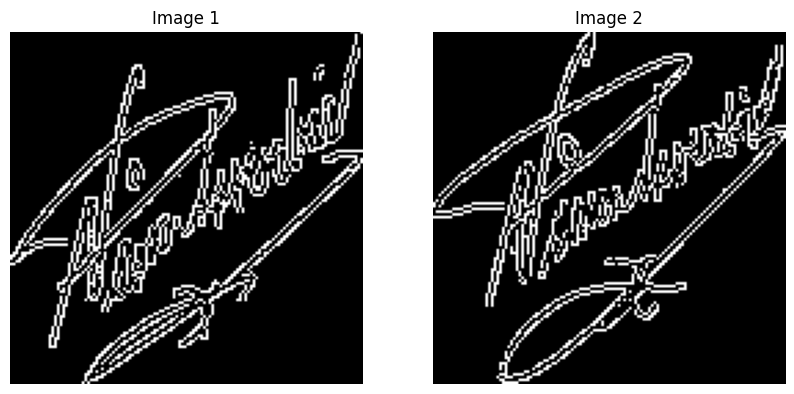

Pair 5
True Label: 0
Predicted Label: [1]


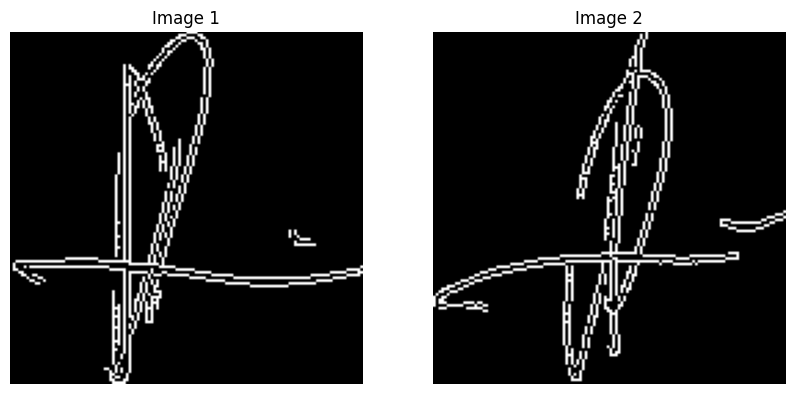

Pair 111
True Label: 0
Predicted Label: [1]


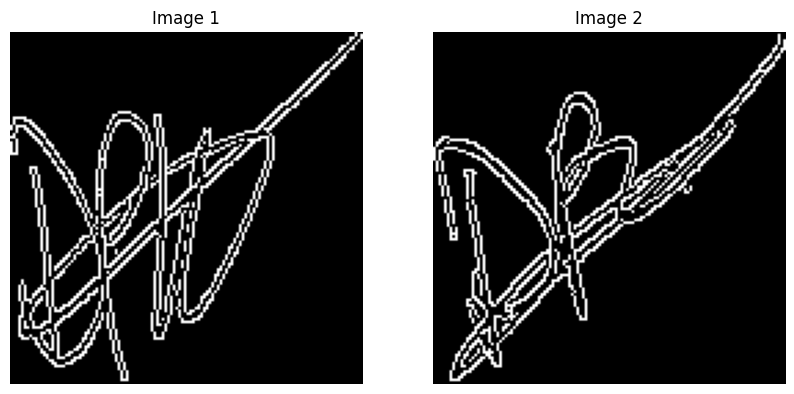

Pair 189
True Label: 1
Predicted Label: [1]


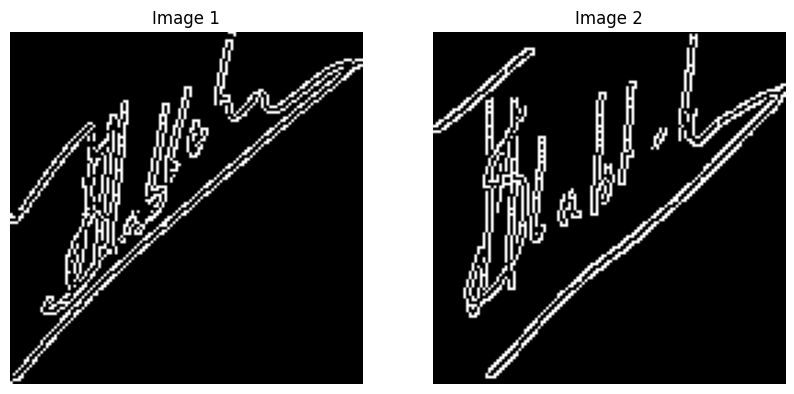

Pair 176
True Label: 1
Predicted Label: [1]


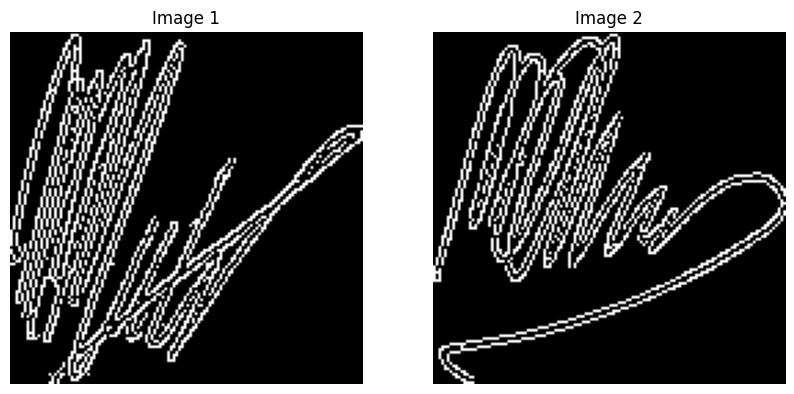

Pair 101
True Label: 1
Predicted Label: [1]


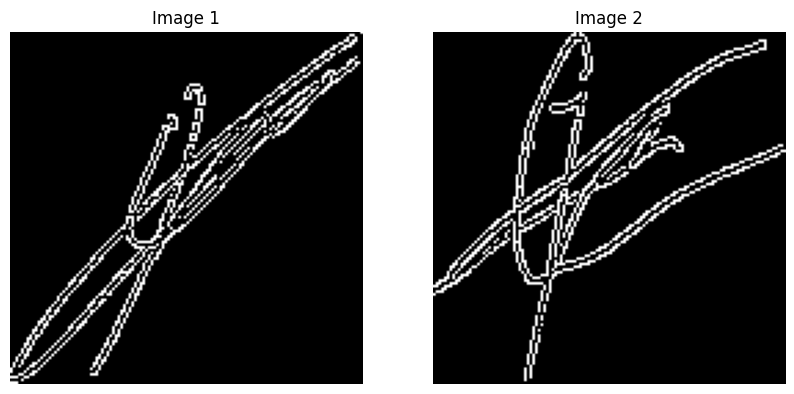

Pair 58
True Label: 0
Predicted Label: [0]


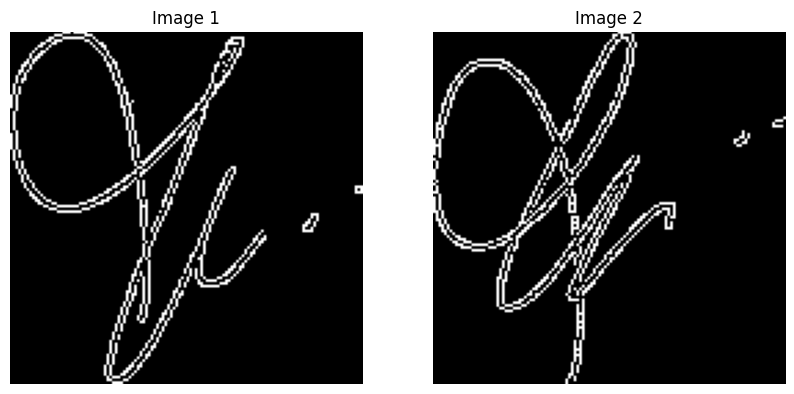

Pair 195
True Label: 1
Predicted Label: [1]


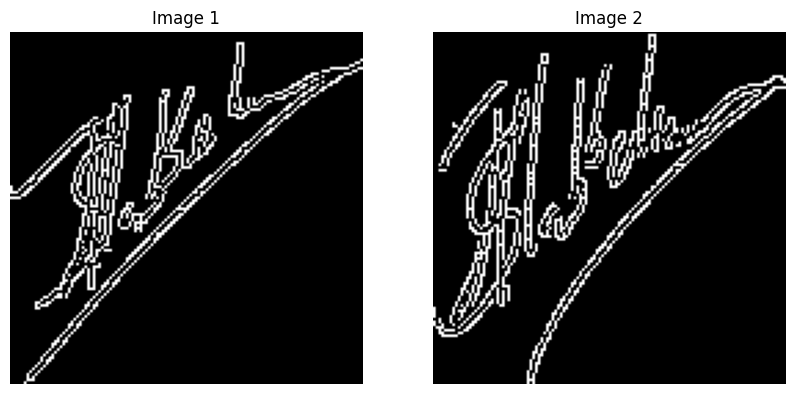

Pair 105
True Label: 1
Predicted Label: [1]


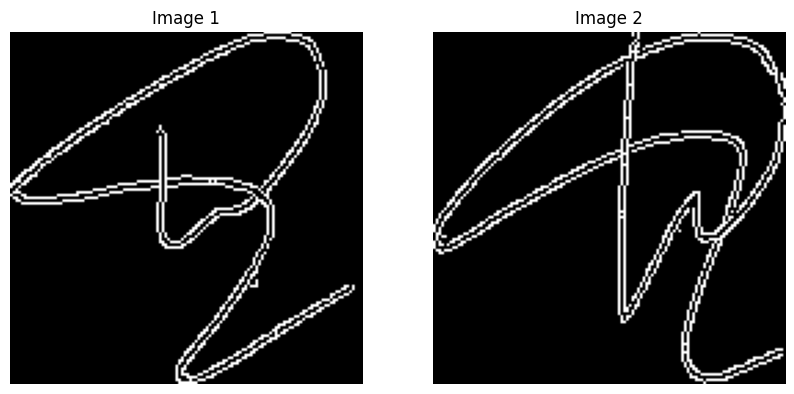

Pair 201
True Label: 1
Predicted Label: [1]


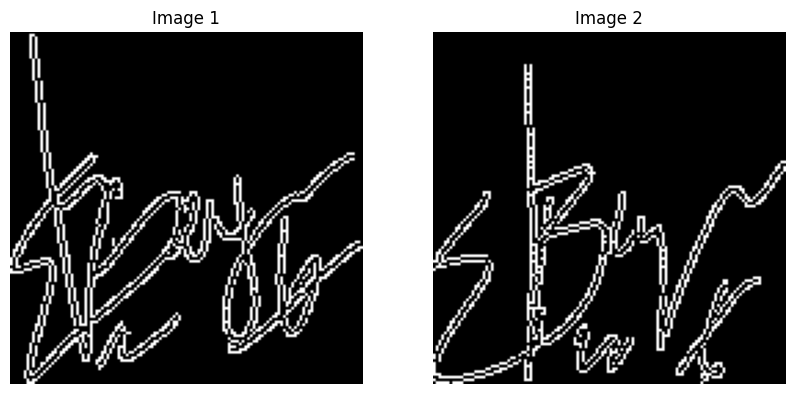

Pair 240
True Label: 1
Predicted Label: [1]


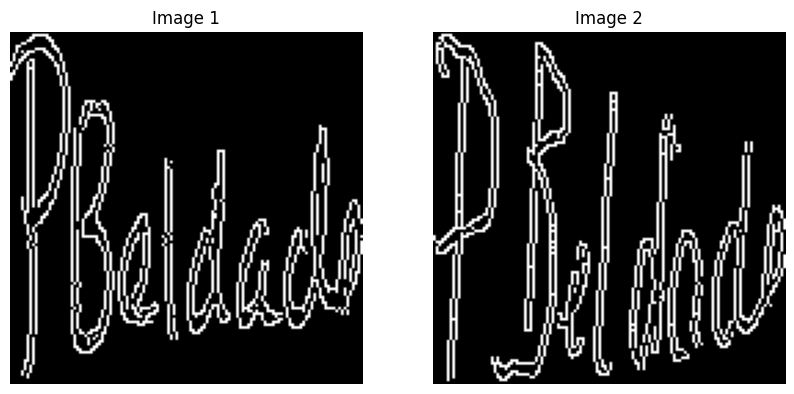

Pair 87
True Label: 0
Predicted Label: [0]


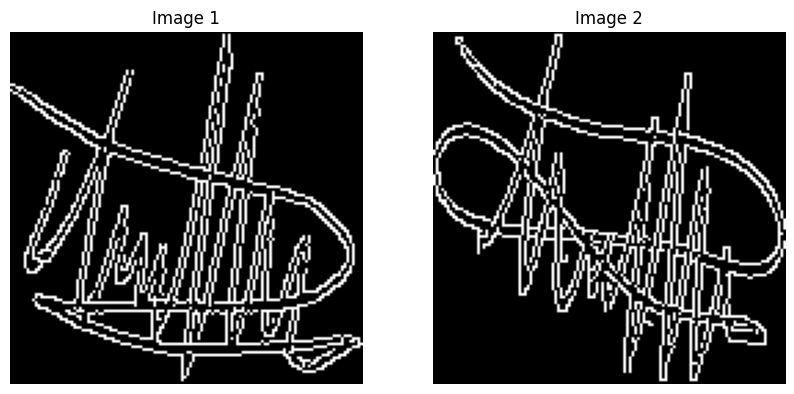

Pair 199
True Label: 1
Predicted Label: [1]


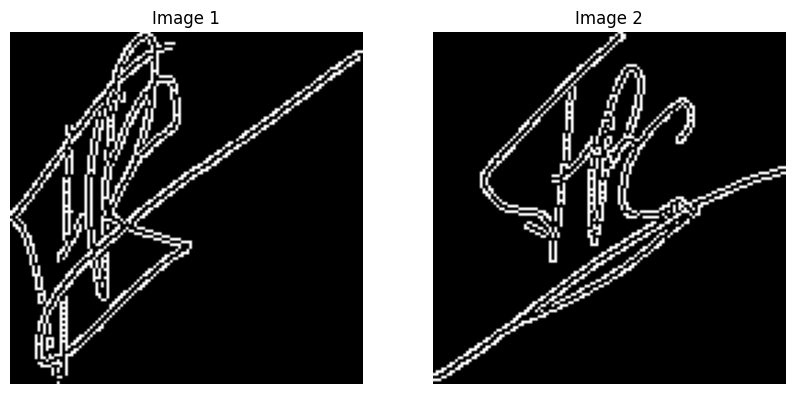

In [17]:
import random

# Getting random 20 pair indices for output
random_indices = random.sample(range(len(test_pairs['image1'])), 20)

# Output random 20 pairs of images, their true labels and predicted labels
for i in random_indices:
    # Получение изображений
    image1 = test_pairs['image1'][i]
    image2 = test_pairs['image2'][i]
    
    # Getting the true label and predicted label
    true_label = test_labels[i]
    predicted_label = binary_predictions[i]
    
    # output
    print("Pair", i+1)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    
    # Отображение изображений
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1.squeeze(), cmap='gray')
    plt.title('Image 1')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2.squeeze(), cmap='gray')
    plt.title('Image 2')
    plt.axis('off')
    
    plt.show()

# Testing on signatures

In [18]:

# Loading the best model
model.load_weights("best_model.kernel")

In [19]:

mytest_dir = "sign_data/test"
mytest_dataset = pd.read_csv('sign_data/test_data.csv', encoding='latin1', header = None)

In [20]:
class CDataLoader:
    def __init__(self, dataset, batch_size, dir):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = dir
    
    def shuffle(self):
        return self.dataset.sample(frac=1)
    
    def preprocess_image(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=1) 
        img = tf.image.resize(img, (128, 128))
        img = tf.cast(img, tf.uint8) 

        img_cv2 = cv2.Canny(img.numpy(), 20, 220) 
        
        img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0
        
        return img_cv2
    
    def datagen(self):
        num_samples = len(self.dataset)
        while True:

            self.dataset = self.shuffle()
            for batch in range(0, num_samples, self.batch_size):
                image1_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 0]]
                image2_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 1]]
                label_batch_samples = self.dataset.iloc[batch:batch + self.batch_size, 2]
                Image1, Image2, Label = [], [], []
                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):

                    image1_data = self.preprocess_image(image1)
                    image2_data = self.preprocess_image(image2)
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)

                Image1 = np.asarray(Image1)
                Image2 = np.asarray(Image2)
                Label = np.asarray(Label)
                yield {"image1": Image1, "image2": Image2}, Label


In [21]:
mytestgen = CDataLoader(mytest_dataset, 2, mytest_dir)

In [22]:
generator = mytestgen.datagen()
batch_data, labels = next(generator)

In [23]:
print("Image1 data shape:", batch_data["image1"].shape)
print("Image2 data shape:", batch_data["image2"].shape)
print("Label data shape:", labels.shape)

Image1 data shape: (2, 128, 128)
Image2 data shape: (2, 128, 128)
Label data shape: (2,)


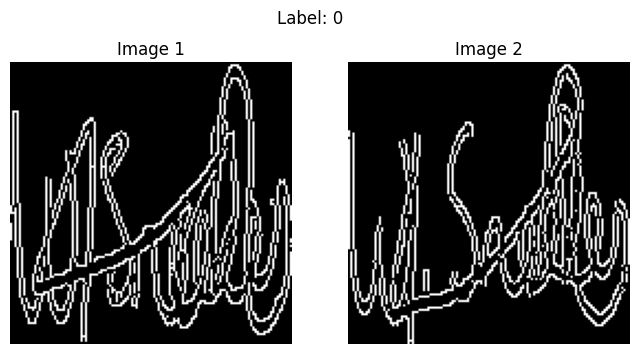

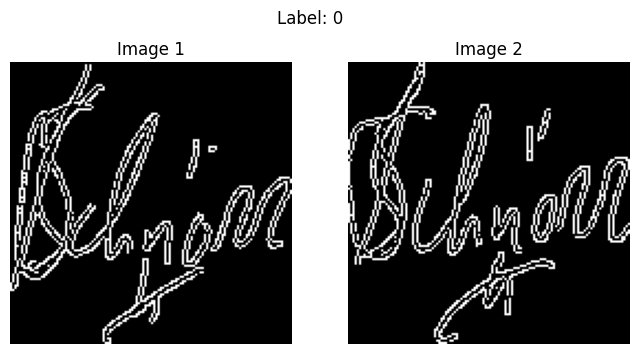

In [24]:
for i in range(len(batch_data["image1"])):
    image1 = batch_data["image1"][i]
    image2 = batch_data["image2"][i]
    label = labels[i]
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.title('Image 1')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap='gray')
    plt.title('Image 2')
    plt.axis('off')
    
    plt.suptitle('Label: ' + str(label))
    plt.show()

In [25]:
mytest_loss, mytest_accuracy = model.evaluate(mytestgen.datagen(),
                                                        steps=len(mytest_dataset) // 2)

2874/2874 [==============================] - 71s 25ms/step - loss: 0.6102 - accuracy: 0.6465


In [26]:
print("Test Loss:", mytest_loss)
print("Test Accuracy:", mytest_accuracy)


Test Loss: 0.6101735830307007
Test Accuracy: 0.6464857459068298


In [27]:
test_pairs, test_labels = next(mytestgen.datagen())

In [28]:
test_predictions = model.predict(test_pairs)

binary_predictions = (test_predictions > 0.5).astype(int)

1/1 [==============================] - 0s 114ms/step


Pair 2
True Label: 1
Predicted Label: [0]


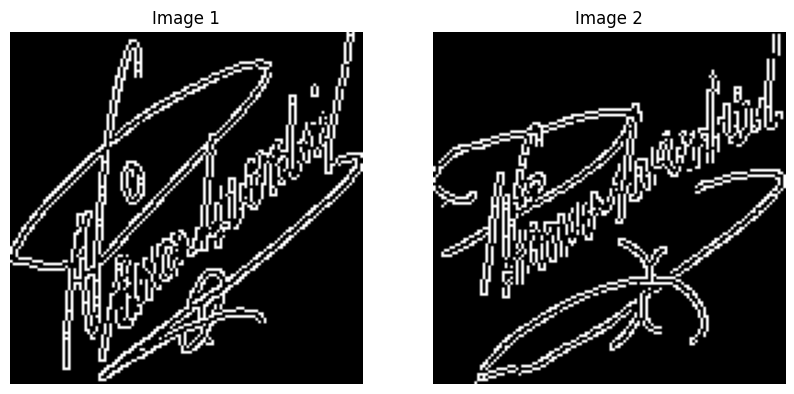

Pair 1
True Label: 0
Predicted Label: [0]


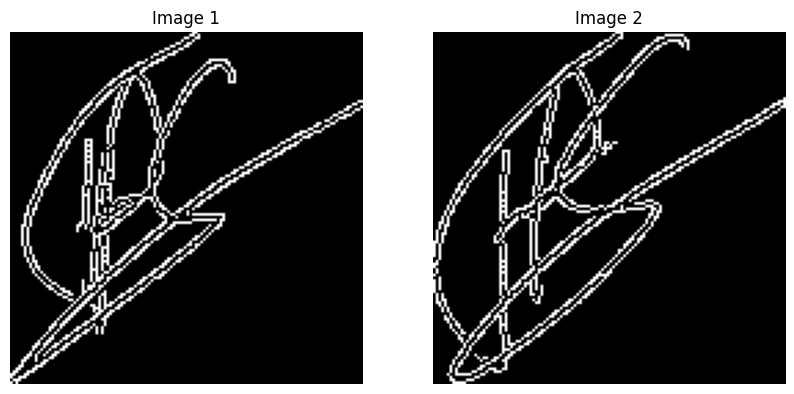

In [29]:
import random

random_indices = random.sample(range(len(test_pairs['image1'])), 2)

for i in random_indices:
    
    image1 = test_pairs['image1'][i]
    image2 = test_pairs['image2'][i]
    
    true_label = test_labels[i]
    predicted_label = binary_predictions[i]
    
    print("Pair", i+1)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1.squeeze(), cmap='gray')
    plt.title('Image 1')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2.squeeze(), cmap='gray')
    plt.title('Image 2')
    plt.axis('off')
    
    plt.show()